# Reconstruction of HBP

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import sirf.STIR as STIR
import scipy.ndimage as ndi
STIR.AcquisitionData.set_storage_scheme('memory')

In [2]:
data_path = '/mnt/share/petric/NeuroLF_Hoffman_Dataset'

In [3]:
STIR.set_verbosity(1)

### Manual re-implementation of RDP gradient

In [4]:
def rdp_grad (inpImm_,kappa_,eps_,pixS_):
    rdpG_ = np.zeros_like(inpImm_)
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
                    print('continuing')
                    continue
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]

                tempW = pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)             
                rdpG_ += tempW*(inpImm_ - shiftImm_)*(inpImm_ + 3 * shiftImm_ + 2* eps_ + 2* np.abs(inpImm_-shiftImm_)) /(np.abs(inpImm_)+ np.abs(shiftImm_) + 2*np.abs(inpImm_-shiftImm_ )+eps_)** 2 
    return rdpG_
    


In [5]:
def rdp_step_size (inpImm_,sDir_,kappa_,eps_,pixS_,alpha_=0):
    ssNum = 0
    ssDen = 0
   # denImm_ = inpImm_ + alpha * sDir_
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
    #                print('continuing')
                    continue
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))
                shiftSI_ = np.roll(sDir_,(zs,xs,ys),axis=(0,1,2))                
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]
                    shiftSI_[-1,:,:] = sDir_[-1,:,:]
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]
                    shiftSI_[0,:,:] = sDir_[0,:,:]
                wI = 1/(np.abs(inpImm_)+ np.abs(shiftImm_) + alpha_ * (sDir_ + shiftSI_) + 2 * np.abs(inpImm_-shiftImm_+ alpha_ * (sDir_ - shiftSI_)) + eps_)
                wI *= pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)
                ssNum -= np.matmul((inpImm_-shiftImm_).flatten().T,((sDir_-shiftSI_)*wI).flat)
                ssDen += np.matmul((shiftSI_-sDir_).flatten().T,((shiftSI_-sDir_)*wI).flat)
    return ssNum,ssDen

In [6]:
def rdp_value (inpImm_,kappa_,eps_,pixS_):
    val=0
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
    #                print('continuing')
                    continue
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))    
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]     
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]
                wI = 1/(np.abs(inpImm_) + np.abs(shiftImm_)  + 2 * np.abs(inpImm_-shiftImm_) + eps_)
                wI *= pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)
                val += np.sum(np.sum(np.sum( (inpImm_-shiftImm_)**2 * wI ,axis=-1),axis=-1),axis=-1)
        return val

## Load images

In [7]:
image = STIR.ImageData(os.path.join(data_path, 'OSEM_image.hv'))
kappa = STIR.ImageData(os.path.join(data_path, 'kappa.hv'))

In [18]:
stir_prior = STIR.CudaRelativeDifferencePrior()
stir_prior.set_epsilon(image.max()*1e-2)
stir_prior.set_penalisation_factor(1/700)
stir_prior.set_kappa(kappa)
stir_prior.set_up(image)

In [9]:
inpImage = image.as_array()

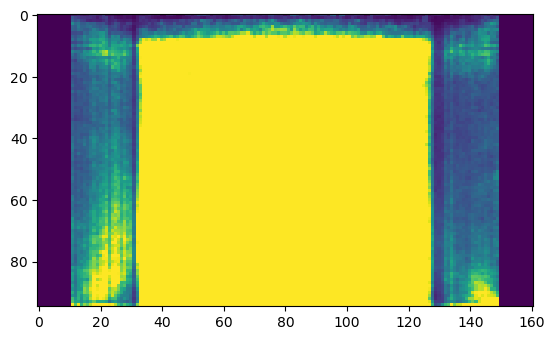

In [10]:
plt.imshow(inpImage[:,120,:],vmax=inpImage.max()*1e-2)

# Reconstruction

## Acquisition model definition

In [11]:
acq_model = STIR.AcquisitionModelUsingParallelproj()
ss_model = STIR.AcquisitionModelUsingParallelproj()
template = STIR.AcquisitionData(os.path.join(data_path, 'prompts.hs'))
multCorr = STIR.AcquisitionData(os.path.join(data_path,'mult_factors.hs'))
addCorr = STIR.AcquisitionData(os.path.join(data_path,'additive_term.hs'))

rMax = addCorr.max()*1e-6
addCorr +=rMax
acq_model.set_acquisition_sensitivity(STIR.AcquisitionSensitivityModel(multCorr))
#
acq_model.set_additive_term(addCorr)
acq_model.set_up(template, image)
#


INFO: Interfile warning: I did not recognise the scanner from 'originating_system' (NeuroLF_15mm). Hopefully there is enough information present. I will check this now.

INFO: Interfile parsing ended up with the following scanner:
Scanner parameters:=
  Scanner type := NeuroLF_15mm
  Number of rings                          := 48
  Number of detectors per ring             := 256
  Inner ring diameter (cm)                 := 26.8
  Average depth of interaction (cm)        := 0.826007
  Distance between rings (cm)              := 0.3313
  Default bin size (cm)                    := 0.16565
  View offset (degrees)                    := -178.143
  Maximum number of non-arc-corrected bins := 180
  Default number of arc-corrected bins     := 180
  Energy resolution         := 0.25
  Reference energy (in keV) := 511
  Number of blocks per bucket in transaxial direction         := 4
  Number of blocks per bucket in axial direction              := 6
  Number of crystals per block in axial dire

In [19]:
ss_model = acq_model.get_linear_acquisition_model()


In [13]:
# templRed = STIR.AcquisitionData(os.path.join(data_path, 'prompts.hs'),max_ring_diff=1,view_mash_factor=2)
# acq_model_red = STIR.AcquisitionModelUsingParallelproj()
# acq_model_red.set_up(templRed,image)

# PGA

## Compute diagonal preconditioner as the diagonal of the hessian 

(BP(attenuation^2))

In [20]:


fwdProj = acq_model.forward(image)
fp1 = ss_model.forward(image.get_uniform_copy(1))
# tFP += addCorr
# tFP *= multCorr
# rMax = addCorr.max()* 1e-6
# tFP += rMax # add a very small number to avoid dividing by 0
#myK = acq_model.backward((template/tFP)*(fp1/tFP))
myK = acq_model.backward(fp1/fwdProj)
myKsqroot = np.sqrt(myK.as_array()+1e-10)
#tFP = []
fp1 = []

In [15]:

myK_4p = (myK.power(0.5) + 1)

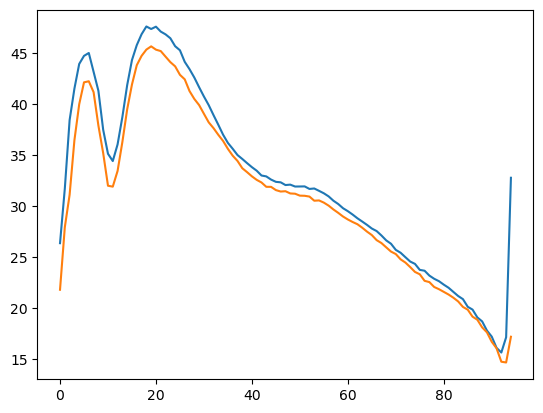

In [16]:
plt.plot(myK_4p.as_array()[:,100,100])
plt.plot(kappa.as_array()[:,100,100])
#plt.ylim(0,500)

In [17]:
stir_prior.set_kappa(myK_4p)
stir_prior.set_up(image)

In [ ]:
plt.imshow(myK.as_array()[20,:,:])

### prior hessian

In [835]:
def rdp_hess (inpImm_,kappa_,eps_,pixS_):
    rdpH_ = np.zeros_like(inpImm_)
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
                    print('continuing')
                    continue
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]

                tempW = pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)             
                rdpH_ += tempW*(16*(inpImm_**1)) /((inpImm_)+ (shiftImm_) + 2*np.abs(inpImm_-shiftImm_ )+eps_)** 3 
    return rdpH_

In [836]:
pHi = 1/700*rdp_hess(inpImage,myK_4p.as_array(),penEps,image.dimensions())

continuing


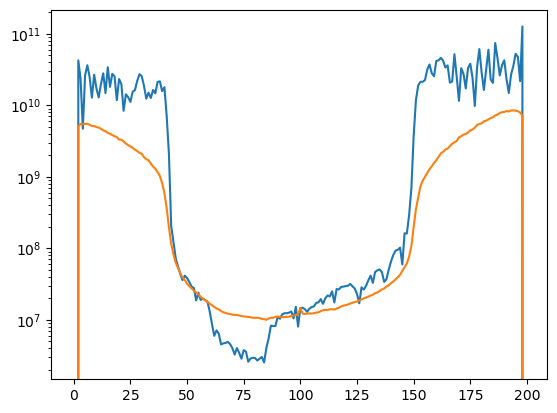

In [844]:
plt.plot(pHi[72,:,100])
plt.plot(myK.as_array()[72,:,100]*200)
plt.yscale('log')

In [433]:
myK.fill(myK.as_array()+pHi)
myKsqroot = np.sqrt(myK.as_array()+1e-10)

Text(0.5, 1.0, 'Profile at pixel 100,100')

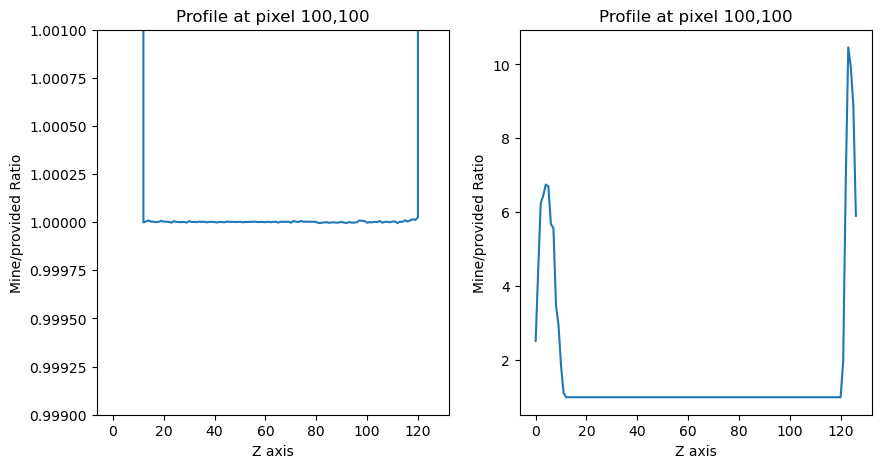

In [609]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(((myK/(kappa.power(2))).as_array())[:,100,100])
#plt.plot((myK.as_array())[:,100,100])
#plt.yscale('log')
plt.ylim(1-.001,1.001)
plt.xlabel('Z axis')
plt.ylabel('Mine/provided Ratio')
plt.title('Profile at pixel 100,100')
plt.subplot(122)
plt.plot(((myK/(kappa.power(2))).as_array())[:,100,100])
plt.xlabel('Z axis')
plt.ylabel('Mine/provided Ratio')
plt.title('Profile at pixel 100,100')
#plt.xlim(0,10)

In [633]:
myK +=.1

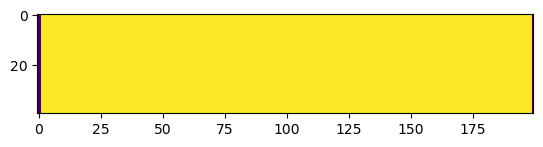

In [632]:
plt.imshow(myK.as_array()[:40,100,:],vmax=1)


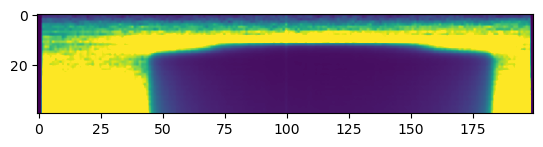

In [530]:
plt.imshow(kappa.as_array()[:40,100,:]**2,vmax=1e6)
#plt.colorbar()

In [511]:
fpOnes = ss_model.forward(image.get_uniform_copy(1))

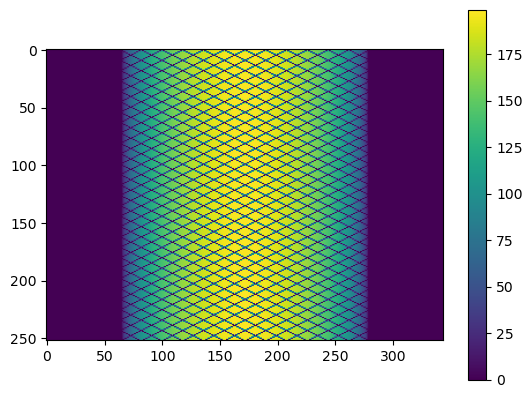

In [528]:
plt.imshow((fpOnes/(multCorr + 1e-10)).as_array()[0,100,:,:])
plt.colorbar()

In [500]:
help (STIR.PoissonLogLikelihoodWithLinearModelForMean.multiply_with_Hessian)

Help on function multiply_with_Hessian in module sirf.STIR:

multiply_with_Hessian(self, current_estimate, input_, subset=-1, out=None)
    Computes the multiplication of the Hessian at current_estimate with a vector.



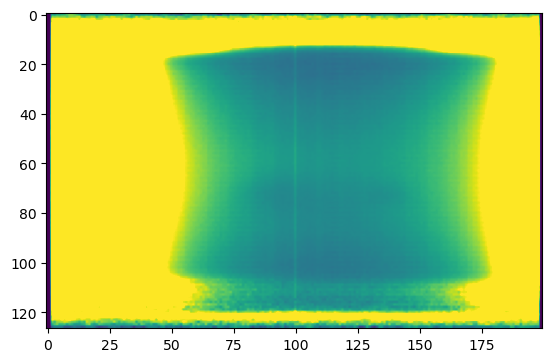

In [254]:
plt.imshow(kappa.as_array() [:,100,:],vmax=500)

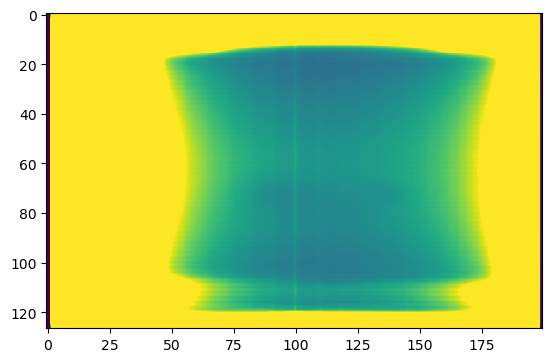

In [255]:
plt.imshow(myK_4p.as_array()[:,100,:],vmax=500)
#plt.colorbar()

### compute masks

In [21]:
mask = kappa.as_array()<1
print(mask.dtype)
mask = ndi.binary_dilation(mask)
print(mask.dtype)
mask = 1 - mask
print(mask.dtype)
#maskImm = STIR.ImageData(
maskS = image.get_uniform_copy(0)
maskS.fill(mask)

bool
bool
int64


In [22]:
stir_prior.get_epsilon()

0.018801722675561905

In [23]:
mask = mask.astype(bool)

In [25]:
penEps = 1e-2*inpImage.max()
myKArr = myKsqroot**2
thr = np.percentile(myKArr[mask],10)*10
maskSDir = myKArr<thr
maskSDir = inpImage>penEps
maskSDir[0,:,:]=0
maskSDir[-1,:,:]=0

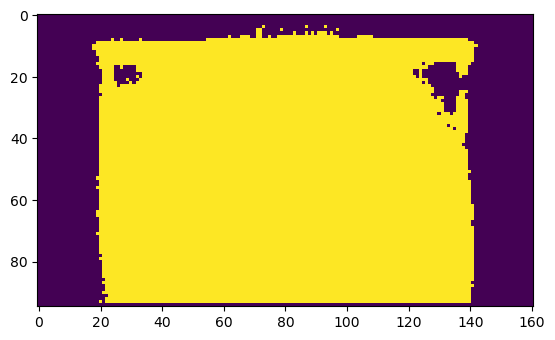

In [26]:
plt.imshow(maskSDir[:,80,:])

In [27]:
inpImage.shape

(95, 161, 161)

The border line often has numerical instability, let alone the area outside the circle which is NaN by definition. Define a mask

In [28]:
def makeFFT_2D_filter (imShape_):
    d_ = .55
    order = np.power(2,np.ceil(np.log2(imShape_[1]))).astype(np.uint32)
   # freqN = np.power(2,np.ceil(np.log2(imShape_[1]//2))).astype(np.uint32)
    print (order)
    freqN = order//2
    imShape_ = inpImage.shape
    nFreq = np.arange(0,freqN +1)
    filtImpResp = np.zeros((len(nFreq),))
    filtImpResp[0]=1/4
    filtImpResp[1::2]=-1/((np.pi*nFreq[1::2])**2)
    filtImpResp = np.concatenate([filtImpResp,filtImpResp[-2:0:-1]])
    ftFilt = 2 * np.real(np.fft.fft(filtImpResp)) # check! when implemented correctly the imag part is zero within numerical precision
    ftFilt = ftFilt[:(freqN+1)]
    
    #fMax = freqN
    fV = 2*np.pi*(np.arange(1,freqN+1))/imShape_[1]
    ftFilt[1:] *= (np.sin(fV/(2*d_)) / (fV/(2*d_)))
    ftFilt[ftFilt<0]=0
    
    xf = np.arange(0,imShape_[1]//2+1).reshape((1,imShape_[1]//2+1))
    yf = xf.transpose()
    freqR = np.sqrt(xf**2+yf**2)
    interpF = np.interp(freqR,nFreq,ftFilt,right=0)
    if (imShape_[1]%2):
        interpF = np.concatenate([interpF,interpF[-1:0:-1,:]],axis=0)
        interpF = np.concatenate([interpF,interpF[:,-1:0:-1]],axis=1)
        interpF = interpF.reshape((1,)+imShape_[1:])
    else:    
        interpF = np.concatenate([interpF,interpF[-2:0:-1,:]],axis=0)
        interpF = np.concatenate([interpF,interpF[:,-2:0:-1]],axis=1)
        interpF = interpF.reshape((1,)+imShape_[1:])
    return interpF
    
    #invFFilt = np.fft.ifft(np.real(ftFilt)) 

#filtImpResp = 


In [29]:
inpImage.shape[1]%2

1

In [30]:
myFilt = makeFFT_2D_filter(inpImage.shape)

256


In [31]:
25600/160

160.0

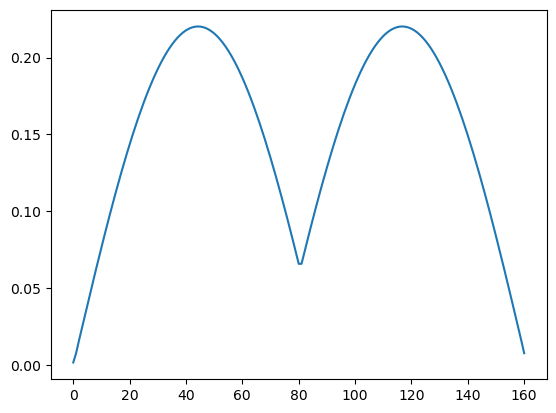

In [32]:
plt.plot(myFilt[0,0,:])

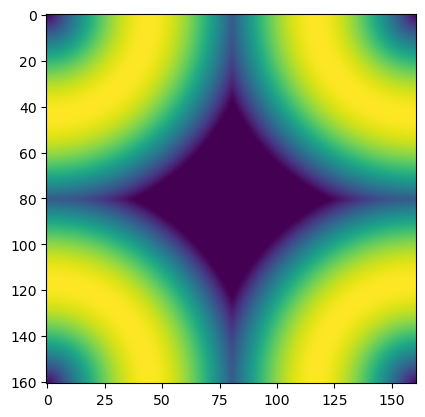

In [33]:
plt.imshow(myFilt[0,:,:])

## Actual recon loop

Recon with preconditioned, maybe conjugate gradient descent

In [95]:
# UNCOMMENT and run to "restart" from the clean image
import time
ts = time.time()
image.fill(inpImage)
print(time.time()-ts)

0.08724665641784668


In [178]:
import scipy.ndimage as ndi

image.fill(ndi.gaussian_filter(inpImage,.75))

In [179]:
acq_model.forward(image,out=fwdProj)

In [37]:
addCorrArray = (addCorr*multCorr).as_array()
addCorrArray += 1e-6*addCorrArray.max()

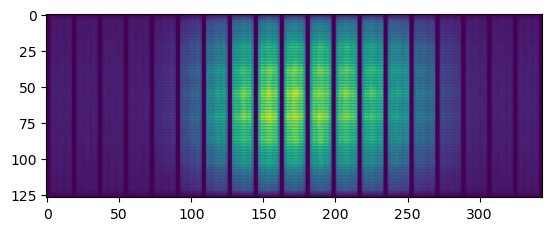

In [241]:
plt.imshow(addCorrArray[0,:127,50,:],vmax=1.)
#plt.colorbar()

In [311]:
1e-3*inpImage.max()

0.0018801722526550293

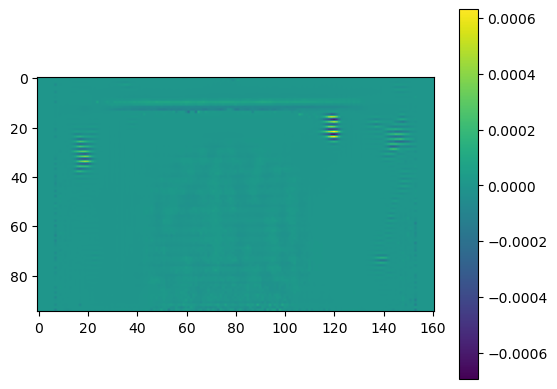

In [386]:
#mask3 = (inpImage>(penEps))
plt.imshow(sDir.as_array()[:,110,:]) #,vmax=0.152)
plt.colorbar()
#plt.contour(mask3[:,100,:],0,colors='r')

In [180]:
nIt = 80
# initialize the current estimate
#addCorr += rMax
#fwdProj = acq_model.forward(image)
#fwdProj += addCorr
#fwdProj *= multCorr 
#fwdProj += rMax
recItV_C2_F_Me3_pos_res = np.zeros((nIt+1,) + inpImage.shape)
recItV_C2_F_Me3_pos_res[0,:,:,:] = image.as_array()
betaPen =  1/700
penEps = 1e-3*inpImage.max()

fPsDir = template.get_uniform_copy(0)
gradI = image.get_uniform_copy(0)
pGrad = image.get_uniform_copy(0)
sDir = image.get_uniform_copy(0)
sinDenoStir = fwdProj.clone()

for itIdx in range(nIt):
 #   gradSino =  (template-fwdProj)/sinDenoStir
    gradSino = template/fwdProj - 1
    acq_model.backward(gradSino,out=gradI) #*multCorr)
    pGrad = stir_prior.gradient(image)
#    pGradA = betaPen*rdp_grad(image.as_array(),kappa.as_array(),penEps,image.voxel_sizes())
#    pGrad.fill(pGradA)
    grad = gradI - pGrad
  #  sDir = grad*maskS / (myK + 1e-10) # avoid dividing by 0. BTW, myK is be definition higher than 1
  # break
  # gradArr = gradI.as_array() - betaPen*rdp_grad(image.as_array(),kappa.as_array(),penEps,image.voxel_sizes())
    gradArr = grad.as_array()
    gradArr /= myKsqroot
    gradArr = np.fft.fft2(gradArr,axes=(1,2))
    gradArr *= myFilt
    gradArr = np.real(np.fft.ifft2(gradArr,axes=(1,2)))
    gradArr = ndi.gaussian_filter(gradArr,(0.5,0,0))
    gradArr /= myKsqroot
    sDir.fill(gradArr*mask)
  # #  

    # Uncomment to conver to conjugate 
    
    if itIdx>0:
        beta = (grad-gradP).dot(sDir)/gradP.dot(prevSDir)
        if itIdx == 30:
            beta = 0
        sDir += beta * prevSDir 
    prevSDir = sDir.clone()
    gradP = grad.clone()   

    ss_model.forward(sDir,out=fPsDir) #*multCorr

    # Tomographic step size
    
    ssNum = sDir.dot(gradI)
#  0  ssDen = fPsDir.dot((fPsDir/fwdProj)*(template/fwdProj))
    ssDen = fPsDir.dot((fPsDir/fwdProj))
#    ssDen = fPsDir.dot((fPsDir/sinDenoStir))
    ssTomo = ssNum/ssDen
    #ss = ssTomo
    # penalty step size
    penSSNum, penSSDen = rdp_step_size(image.as_array(),sDir.as_array(),kappa.as_array()*maskSDir,penEps,image.voxel_sizes())
    ss = (ssNum+2*betaPen*penSSNum)/(ssDen+2*betaPen*penSSDen)
    print ('num: {:.1e} den: {:.1e} penNum {:.1e} penDen {:.1e}'.format(ssNum,ssDen,2*betaPen*penSSNum,2*betaPen*penSSDen))
#    break
    
    # update image and sinogram
    prevImm = image.clone()
    image += ss*sDir
    fwdProj += ss*fPsDir
 #   print(ss)

# UNCOMMENT to update sinogram in each iteration
    

    imArr = image.as_array()
    imArr[imArr<0]=0
    imArr[np.isnan(imArr)] = 0
    image.fill(imArr)
    acq_model.forward(image,out=fwdProj)
    prevSDir = (image - prevImm)/ss

    # sinDeno = fwdProj.as_array()
    # sinDeno[sinDeno<addCorrArray] = addCorrArray[sinDeno<addCorrArray]
    # sinDenoStir.fill(sinDeno)
    # ts = time.time()
    # fwdProj += addCorr 
    # t1 = time.time()
    # fwdProj *= multCorr 
    # t2 = time.time()
   # if (itIdx%20)==0:
   #  print(itIdx)
    

  #  fwdProj+= ss/ssDen*fPsDir
    recItV_C2_F_Me3_pos_res[itIdx+1,:,:,:] = image.as_array()
    

num: 3.2e+04 den: 3.7e+02 penNum -8.9e+02 penDen 5.6e+01
num: 1.8e+04 den: 2.5e+02 penNum 2.4e+03 penDen 2.0e+02
num: 2.4e+04 den: 8.7e+02 penNum -6.6e+03 penDen 7.6e+02
num: 2.3e+04 den: 5.9e+02 penNum 2.7e+03 penDen 7.1e+02
num: 2.1e+04 den: 3.9e+02 penNum 2.9e+03 penDen 5.4e+02
num: 2.0e+04 den: 6.6e+02 penNum -4.2e+03 penDen 7.2e+02
num: 1.0e+05 den: 2.7e+05 penNum 2.1e+05 penDen 4.5e+05
num: 2.1e+04 den: 3.2e+02 penNum 5.5e+03 penDen 4.1e+02
num: 2.3e+04 den: 5.5e+02 penNum -4.1e+03 penDen 8.0e+02
num: 2.4e+04 den: 4.9e+02 penNum 1.9e+04 penDen 2.3e+03
num: 2.0e+04 den: 2.9e+02 penNum -3.9e+02 penDen 1.9e+02
num: 2.1e+04 den: 1.1e+03 penNum -1.9e+04 penDen 3.1e+03
num: 1.9e+04 den: 3.0e+02 penNum 7.6e+03 penDen 5.6e+02
num: 1.6e+04 den: 3.0e+02 penNum -5.7e+03 penDen 1.4e+03
num: 2.3e+04 den: 3.4e+02 penNum 9.6e+03 penDen 8.2e+02
num: 2.3e+04 den: 3.6e+02 penNum -8.6e+03 penDen 1.0e+03
num: 2.3e+04 den: 3.7e+02 penNum 1.4e+04 penDen 9.6e+02
num: 2.3e+04 den: 3.7e+02 penNum -4.8e+0

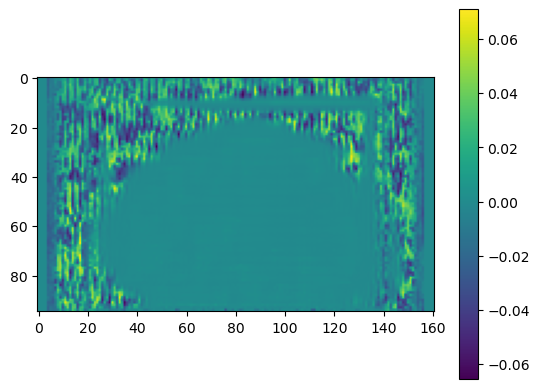

In [181]:
#mask3 = (inpImage>(penEps))
plt.imshow(ss*sDir.as_array()[:,:,60])#,vmax=0.00152)
plt.colorbar()
#plt.contour(mask3[:,100,:],0,colors='r')

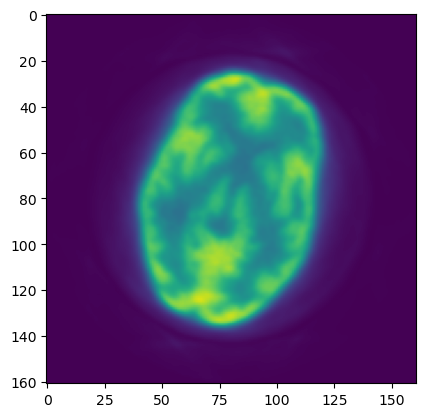

In [100]:
plt.imshow(recItV_C_F_M2[0,75,:,:],vmin=0,vmax=1.75)
#plt.colorbar()

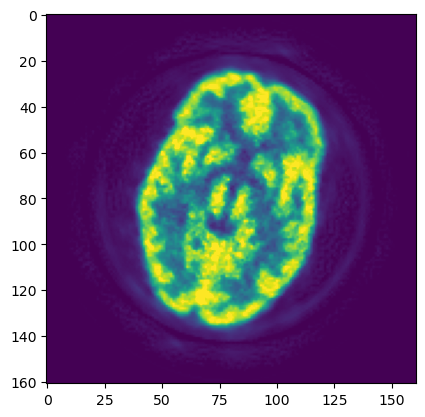

In [162]:
plt.imshow(image.as_array()[75,:,:],vmin=0,vmax=1.75) #,vmax=1.7)
#plt.colorbar()


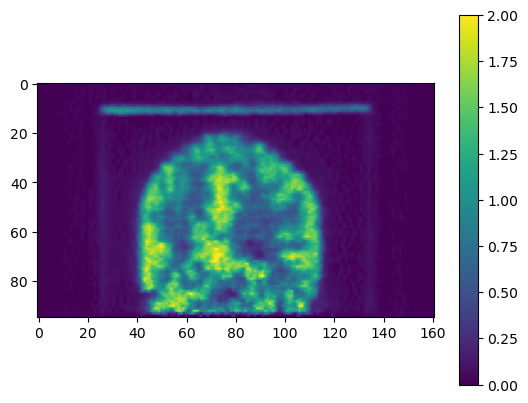

In [163]:
plt.imshow((image.as_array())[:,100,:],vmin=0,vmax=2)
plt.colorbar()

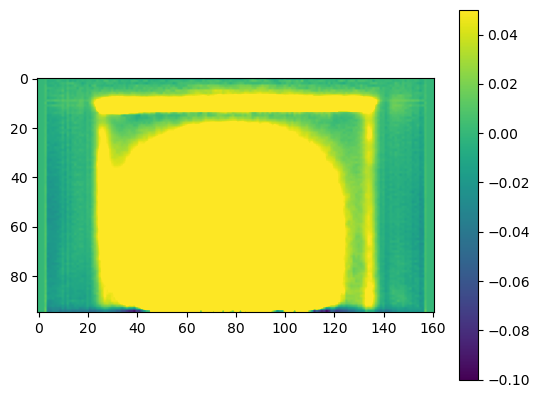

In [164]:
plt.imshow((recItV_C__Me3)[1,:,100,:],vmin=-.1,vmax=.05)
plt.colorbar()

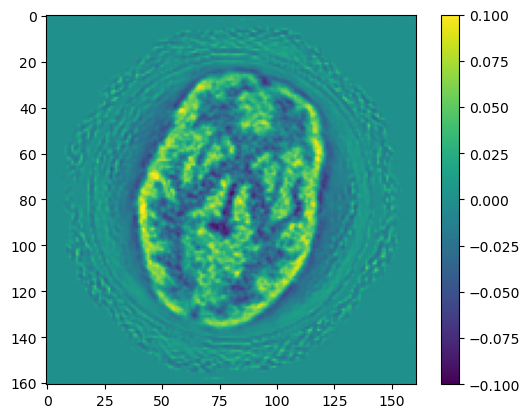

In [167]:
plt.imshow(recItV_C2_F_Me3_pos[2,72,:,:]-recItV_C2_F_Me3_pos[1,72,:,:],vmin=-.1,vmax=.1)
plt.colorbar()

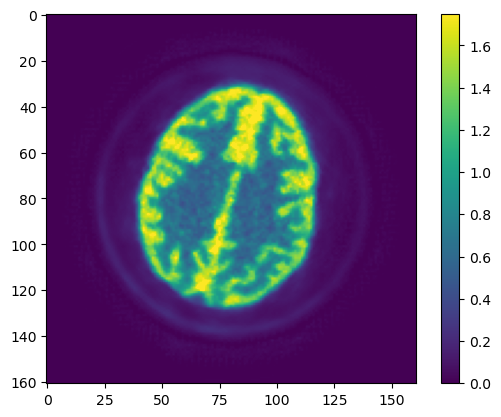

In [182]:
plt.imshow(image.as_array()[50,:,:],vmin=0,vmax=1.75)
plt.colorbar()

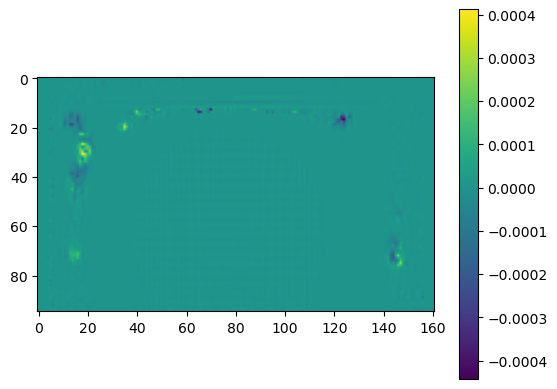

In [66]:
plt.imshow(-sDir.as_array()[:,100,:]) #,vmax=0.152)
plt.colorbar()

### Plot some images

In [39]:
recImmCG = STIR.ImageData('/workdir/refs/NeuroLF_Hoffman/reference_image.hv').as_array()

Text(0, 0.5, 'Difference norm')

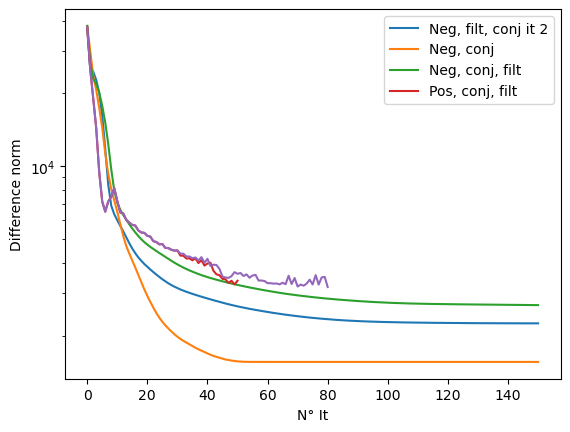

In [183]:
dV = np.sum(np.sum(np.sum((recItV_C2_F_Me3[:,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
plt.plot(dV)
dV = np.sum(np.sum(np.sum((recItV_C__Me3[:,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
plt.plot(dV)
dV = np.sum(np.sum(np.sum((recItV_C_F_Me3[:,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
plt.plot(dV)

dV = np.sum(np.sum(np.sum((recItV_C2_F_Me3_pos[:,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
plt.plot(dV)


# # 

# dV = np.sum(np.sum(np.sum((recItV_C2_F_Me3_pos_res[:,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
# plt.plot(dV)


# dV = np.sum(np.sum(np.sum((recItV_P5[:,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
# plt.plot(dV)
plt.yscale('log')
plt.legend(['Neg, filt, conj it 2','Neg, conj','Neg, conj, filt','Pos, conj, filt'])
plt.xlabel('N° It')
plt.ylabel('Difference norm')
#plt.xlim((0,10))
#plt.ylim((4e3,4e4))


(4000.0, 40000.0)

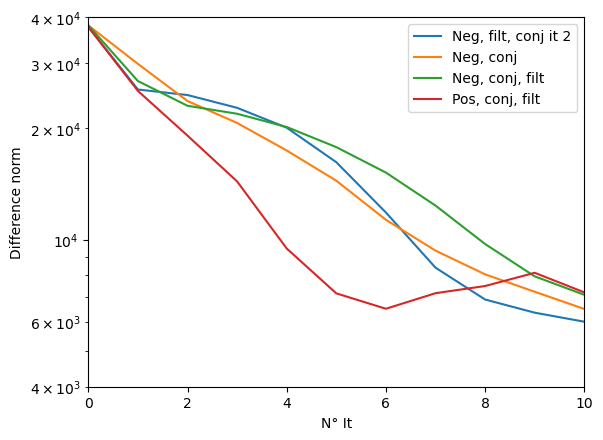

In [184]:
dV = np.sum(np.sum(np.sum((recItV_C2_F_Me3[:,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
plt.plot(dV)
dV = np.sum(np.sum(np.sum((recItV_C__Me3[:,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
plt.plot(dV)
dV = np.sum(np.sum(np.sum((recItV_C_F_Me3[:,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
plt.plot(dV)

dV = np.sum(np.sum(np.sum((recItV_C2_F_Me3_pos[:,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
plt.plot(dV)

plt.yscale('log')
plt.legend(['Neg, filt, conj it 2','Neg, conj','Neg, conj, filt','Pos, conj, filt'])
plt.xlabel('N° It')
plt.ylabel('Difference norm')
plt.xlim((0,10))
plt.ylim((4e3,4e4))


# Test step sizes of priors

In [445]:
inpImm_ = inpImage
sDir_ = sDir.as_array() #(grad/(myK+1e-10)).as_array()
eps_ = penEps
pixS_ = image.voxel_sizes()
kappa_ = kappa.as_array().copy()*maskSDir #kappa.as_array()
alpha_ = 0

In [446]:
ssNum = 0
ssDen = 0
   # denImm_ = inpImm_ + alpha * sDir_
for xs in range(-1,2):
    for ys in range (-1,2):
        for zs in range(0,2):
            if (xs == 0) and (ys==0) and (zs==0): 
    #                print('continuing')
                continue
            shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))
            shiftSI_ = np.roll(sDir_,(zs,xs,ys),axis=(0,1,2))                
            sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
            if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]
                    shiftSI_[-1,:,:] = sDir_[-1,:,:]
            if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]
                    shiftSI_[0,:,:] = sDir_[0,:,:]
            wI = 1/(np.abs(inpImm_)+ np.abs(shiftImm_) + alpha_ * (sDir_ + shiftSI_) + 2 * np.abs(inpImm_-shiftImm_+ alpha_ * (sDir_ - shiftSI_)) + eps_)
            wI *= pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)
            ssNum -= np.matmul((inpImm_-shiftImm_).flatten().T,((sDir_-shiftSI_)*wI).flat)
            ssDen += np.matmul((shiftSI_-sDir_).flatten().T,((shiftSI_-sDir_)*wI).flat)
            break
        break
    break

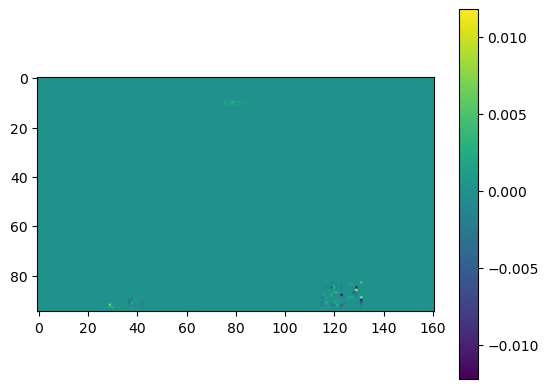

In [461]:
plt.imshow(((inpImm_-shiftImm_)*wI*((sDir_-shiftSI_)))[:,:,20]) #,vmax=.8)
plt.colorbar()